In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle


In [12]:
# Load your data into a pandas DataFrame
df = pd.read_csv("data/powerconsumption.csv");
df.drop(["DiffuseFlows"], axis=1, inplace=True)
df.Datetime = pd.to_datetime(df.Datetime);
reference_datetime = pd.to_datetime("01/01/2017 00:00", format='%d/%m/%Y %H:%M')
df.Datetime = ((df['Datetime'] - reference_datetime).dt.total_seconds() // 60) % 60
df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,0.0,6.559,73.8,0.083,0.051,34055.69620,16128.87538,20240.96386
1,10.0,6.414,74.5,0.083,0.070,29814.68354,19375.07599,20131.08434
2,20.0,6.313,74.5,0.080,0.062,29128.10127,19006.68693,19668.43373
3,30.0,6.121,75.0,0.083,0.091,28228.86076,18361.09422,18899.27711
4,40.0,5.921,75.7,0.081,0.048,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
52411,10.0,7.010,72.4,0.080,0.040,31160.45627,26857.31820,14780.31212
52412,20.0,6.947,72.6,0.082,0.051,30430.41825,26124.57809,14428.81152
52413,30.0,6.900,72.8,0.086,0.084,29590.87452,25277.69254,13806.48259
52414,40.0,6.758,73.0,0.080,0.066,28958.17490,24692.23688,13512.60504


In [13]:
# Define the features and target variable
features = ["Datetime", "Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows"]
target = ['PowerConsumption_Zone1']

X = df[features]
y = df[target]

In [14]:
# Normalize the features and target using Min-Max scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)


In [15]:
# Define the number of time steps (days)
time_steps = 6*24

In [16]:
# Create sequences for LSTM input
X_sequences = []
y_sequences = []

In [17]:
for i in range(len(X_scaled) - time_steps + 1):
    X_sequences.append(X_scaled[i:i+time_steps, :])
    # Use the avg of the last consumption as target of the last 7 days
    y_sequences.append(np.mean(y_scaled[i:i+time_steps, 0]))
    # y_sequences.append(y_scaled[i+time_steps-1, 0])  # Use the last day's power consumption as target

# X_sequences = np.array(X_scaled.reshape(len(X_scaled), 1, 5))
# y_sequences = np.array(y_scaled)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)



In [24]:
# Create and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.ravel())  # Ravel y_train to convert it to a 1D array



RandomForestRegressor(random_state=42)

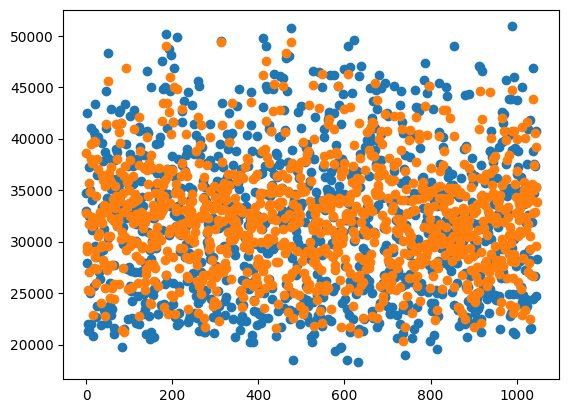

Mean Squared Error: 22465712.89


In [28]:
# Make predictions using the test dataset
y_pred = rf_model.predict(X_test)

# Inverse transform the scaled predictions to the original scale
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Inverse transform the scaled actual values (if needed)
y_actual_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_actual_plt = y_actual_original[:len(y_actual_original)//10]
y_pred_plt = y_pred_original[:len(y_actual_original)//10]
fig,ax = plt.subplots()
ax.scatter(range(len(y_actual_plt)), y_actual_plt)
ax.scatter(range(len(y_pred_plt)), y_pred_plt)
plt.show()


# Calculate performance metrics (e.g., Mean Squared Error)
mse = mean_squared_error(y_actual_original, y_pred_original)
print(f"Mean Squared Error: {mse:.2f}")


In [39]:
# Upload to minio server
from minio import Minio

with open("xgboost", "wb") as mod:
    pickle.dump(rf_model, mod)

minio_client = Minio(
    "172.20.126.215:9000",
    access_key="minio",
    secret_key="minio123",
    secure=False
)
minio_bucket = "mlpipeline"
minio_client.fput_object(minio_bucket, "xgboost", "xgboost")

Mean Squared Error: 22465712.89
